In [1]:
import numpy as np

# queueing example
class Queue:
  def __init__(self,
               buffer_size = 20,
               prob_arrival = 0.5,
               prob_fast_service = 0.7,
               prob_slow_service = 0.4):
    self.buffer_size = buffer_size
    self.prob_arrival = prob_arrival
    self.prob_fast_service = prob_fast_service
    self.prob_slow_service = prob_slow_service
    self.queue_length = 0
  
  def step(self, action):
    arrival_token = np.random.binomial(1, self.prob_arrival)
    departure_token = np.random.binomial(1, self.prob_fast_service if action=='fast' else self.prob_slow_service)
    abandonment = max(self.queue_length + arrival_token - departure_token - self.buffer_size, 0)
    self.queue_length = max(min(self.queue_length + arrival_token - departure_token, self.buffer_size), 0)
    observation = (self.queue_length, abandonment)
    return observation

  def transition_probs(self, queue_length, action):
    prob_departure = self.prob_fast_service if action=='fast' else self.prob_slow_service
    prob_increase = self.prob_arrival * (1-prob_departure) if queue_length < self.buffer_size else 0.0
    prob_decrease = (1-self.prob_arrival) * prob_departure if queue_length > 0 else 0.0
    prob_same = 1 - prob_increase - prob_decrease
    prob_abandonment = 0 if queue_length<self.buffer_size else self.prob_arrival*(1-prob_departure)
    return prob_decrease, prob_same, prob_increase, prob_abandonment

def reward(action, observation, fast_cost=30.0, slow_cost=0.0, abandonment_cost=500):
  length = observation[0]
  abandonment = observation[1]
  return -length - abandonment * abandonment_cost - (fast_cost if action=='fast' else slow_cost)

## 1a)

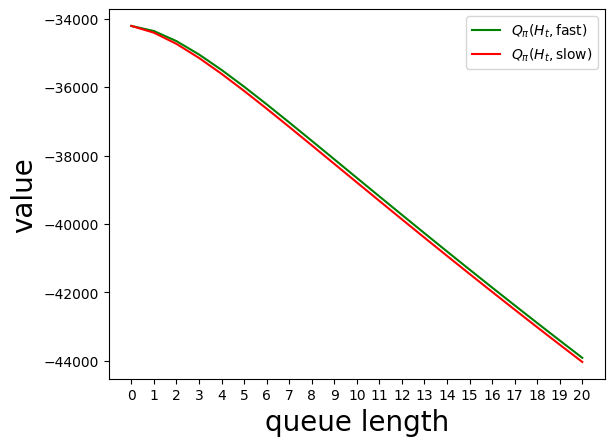

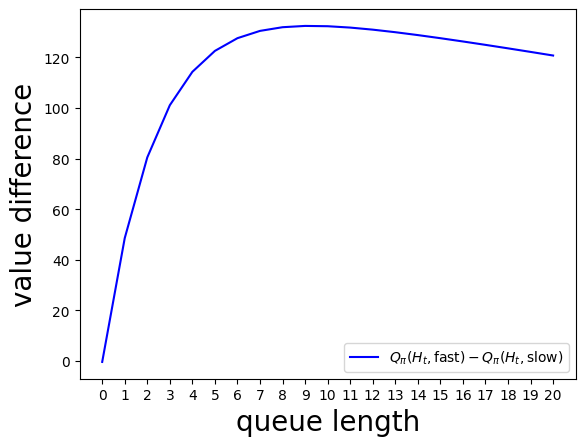

In [2]:
# compute policy value function for policy that always selects slow mode
queue = Queue()
T = 1000
discount_factor = .999

# compute policy value function
action_list = ['fast', 'slow']
Q = {a:np.zeros(queue.buffer_size+1) for a in action_list}
for iter in range(T):
  Q_update = {a:np.zeros(queue.buffer_size+1) for a in action_list}
  for a in action_list:
    for queue_length in range(queue.buffer_size+1):
      prob_decrease, prob_same, prob_increase, prob_abandonment = queue.transition_probs(queue_length, a)
      Q_next = (
          prob_decrease * Q['slow'][max(queue_length-1,0)] + 
          prob_same * Q['slow'][queue_length] + 
          prob_increase * Q['slow'][min(queue_length+1, queue.buffer_size)]
      )
      Q_update[a][queue_length] = (
          (1 - prob_abandonment) * reward(a, (queue_length, 0)) + 
          prob_abandonment * reward(a, (queue_length, 1)) + 
          discount_factor * Q_next
      )
  Q = Q_update

# plot policy value function
import matplotlib.pyplot as plt
import pylab
queue_lengths = range(queue.buffer_size+1)
plt.plot(queue_lengths, [q for q in Q['fast']], 'green', label=r'$Q_\pi(H_t, \mathrm{fast})$')
plt.plot(queue_lengths, [q for q in Q['slow']], 'red', label=r'$Q_\pi(H_t, \mathrm{slow})$')
plt.xticks(queue_lengths)
plt.xlabel(r'queue length', fontsize=20)
plt.ylabel('value', fontsize=20)
pylab.legend(loc='best')
plt.show()

# plot difference between value functions
import matplotlib.pyplot as plt
import pylab
queue_lengths = range(queue.buffer_size+1)
plt.plot(queue_lengths, [q_fast-q_slow for (q_fast,q_slow) in zip(Q['fast'],Q['slow'])], 'blue', label='$Q_\pi(H_t, \mathrm{fast}) - Q_\pi(H_t, \mathrm{slow})$')
plt.xticks(queue_lengths)
plt.xlabel(r'queue length', fontsize=20)
plt.ylabel('value difference', fontsize=20)
pylab.legend(loc='best')
plt.show()

# cache value function
V_pi = Q['slow'].copy()

## 1b)

['slow', 'fast', 'fast', 'fast', 'fast', 'fast', 'fast', 'fast', 'fast', 'fast', 'fast', 'fast', 'fast', 'fast', 'fast', 'fast', 'fast', 'fast', 'fast', 'fast', 'fast']


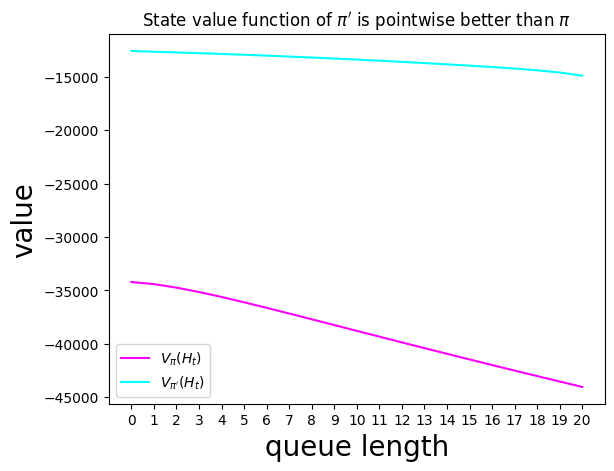

In [3]:
# pi'
policy = (queue.buffer_size + 1) * [None] 
for length in range(len(policy)):
  policy[length] = action_list[np.argmax([Q[a][length] for a in action_list])]
print(policy)

# Q pi'
action_list = ['fast', 'slow']
Q = {a:np.zeros(queue.buffer_size+1) for a in action_list}
for iter in range(T):
  Q_update = {a:np.zeros(queue.buffer_size+1) for a in action_list}
  for a in action_list:
    for queue_length in range(queue.buffer_size+1):
      prob_decrease, prob_same, prob_increase, prob_abandonment = queue.transition_probs(queue_length, a)
      Q_next = (
          prob_decrease * Q[policy[queue_length]][max(queue_length-1,0)] + 
          prob_same * Q[policy[queue_length]][queue_length] + 
          prob_increase * Q[policy[queue_length]][min(queue_length+1, queue.buffer_size)]
      )
      Q_update[a][queue_length] = (
          (1 - prob_abandonment) * reward(a, (queue_length, 0)) + 
          prob_abandonment * reward(a, (queue_length, 1)) + 
          discount_factor * Q_next
      )
  Q = Q_update

V_pi_prime = np.array([
  Q[policy[size]][size]
  for size in range(queue.buffer_size+1)
])

# plot value functions
import matplotlib.pyplot as plt
import pylab
queue_lengths = range(queue.buffer_size+1)
plt.plot(queue_lengths, V_pi, 'magenta', label=r'$V_\pi(H_t)$')
plt.plot(queue_lengths, V_pi_prime, 'cyan', label=r'$V_{\pi^{\prime}}(H_t)$')
plt.xticks(queue_lengths)
plt.xlabel(r'queue length', fontsize=20)
plt.ylabel('value', fontsize=20)
plt.title("State value function of $\pi^{\prime}$ is pointwise better than $\pi$")
pylab.legend(loc='best')
plt.show()

## 1c)

In [49]:
# value iteration
import copy
import tqdm

queue = Queue()
T = 10000
discount_factor = .999
num_updates = 20

# compute optimal action value function
action_list = ['fast', 'slow']
Q = {a: np.zeros(queue.buffer_size + 1) for a in action_list}
for iter in range(T):
    Q_update = {a: np.zeros(queue.buffer_size + 1) for a in action_list}
    for a in action_list:
        for queue_length in range(queue.buffer_size + 1):
            prob_decrease, prob_same, prob_increase, prob_abandonment = queue.transition_probs(queue_length, a)
            V = np.maximum.reduce([Q[b] for b in action_list])
            Q_next = (
                prob_decrease * V[max(queue_length - 1, 0)] + 
                prob_same * V[queue_length] + 
                prob_increase * V[min(queue_length + 1, queue.buffer_size)]
            )
            Q_update[a][queue_length] = (
                (1 - prob_abandonment) * reward(a, (queue_length, 0)) +
                prob_abandonment * reward(a, (queue_length, 1)) +
                discount_factor * Q_next
            )
    Q = Q_update
Q_value_iteration = copy.deepcopy(Q)
del Q, V, Q_update

# policy iteration
policy = (queue.buffer_size + 1) * ['slow']
for _ in tqdm.tqdm(range(num_updates)):
    Q = {a: np.zeros(queue.buffer_size + 1) for a in action_list}
    for iter in range(T):
        Q_update = {a: np.zeros(queue.buffer_size + 1) for a in action_list}
        for a in action_list:
            for queue_length in range(queue.buffer_size + 1):
                prob_decrease, prob_same, prob_increase, prob_abandonment = queue.transition_probs(queue_length, a)
                Q_next = (
                    prob_decrease * Q[policy[max(queue_length - 1, 0)]][max(queue_length - 1, 0)] +
                    prob_same * Q[policy[queue_length]][queue_length] +
                    prob_increase * Q[policy[min(queue_length + 1, queue.buffer_size)]][min(queue_length + 1, queue.buffer_size)]
                )
                Q_update[a][queue_length] = (
                    (1 - prob_abandonment) * reward(a, (queue_length, 0)) +
                    prob_abandonment * reward(a, (queue_length, 1)) +
                    discount_factor * Q_next
                )
        Q = Q_update
    for length in range(len(policy)):
        policy[length] = action_list[np.argmax([Q[a][length] for a in action_list])]
Q_policy_iteration = copy.deepcopy(Q)

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:12<00:00,  1.56it/s]


[-0.02555179 -0.02555179 -0.02555179 -0.02555179 -0.02555179 -0.02555179
 -0.02555179 -0.02555179 -0.02555179 -0.02555179 -0.02555179 -0.02555179
 -0.02555179 -0.02555179 -0.02555179 -0.02555179 -0.02555179 -0.02555179
 -0.02555179 -0.02555179 -0.02555179]
[-0.02555179 -0.02555179 -0.02555179 -0.02555179 -0.02555179 -0.02555179
 -0.02555179 -0.02555179 -0.02555179 -0.02555179 -0.02555179 -0.02555179
 -0.02555179 -0.02555179 -0.02555179 -0.02555179 -0.02555179 -0.02555179
 -0.02555179 -0.02555179 -0.02555179]


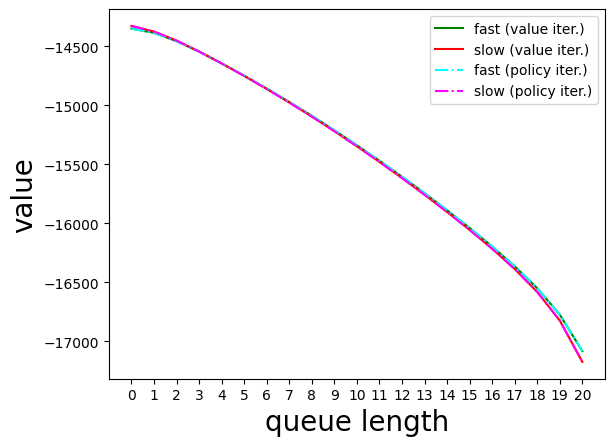

In [50]:
# plot policy value function
import matplotlib.pyplot as plt
import pylab
queue_lengths = range(queue.buffer_size+1)
plt.plot(queue_lengths, [q for q in Q_value_iteration['fast']], 'green', label=r'fast (value iter.)')
plt.plot(queue_lengths, [q for q in Q_value_iteration['slow']], 'red', label=r'slow (value iter.)')

plt.plot(queue_lengths, [q for q in Q_policy_iteration['fast']], 'cyan', label=r'fast (policy iter.)', linestyle='-.')
plt.plot(queue_lengths, [q for q in Q_policy_iteration['slow']], 'magenta', label=r'slow (policy iter.)', linestyle='-.')

# check difference btw value and policy iteration
print(Q_policy_iteration['slow'] - Q_value_iteration['slow'])
print(Q_policy_iteration['fast'] - Q_value_iteration['fast'])

plt.xticks(queue_lengths)
plt.xlabel(r'queue length', fontsize=20)
plt.ylabel('value', fontsize=20)
pylab.legend(loc='best')
plt.show()

## 1d)

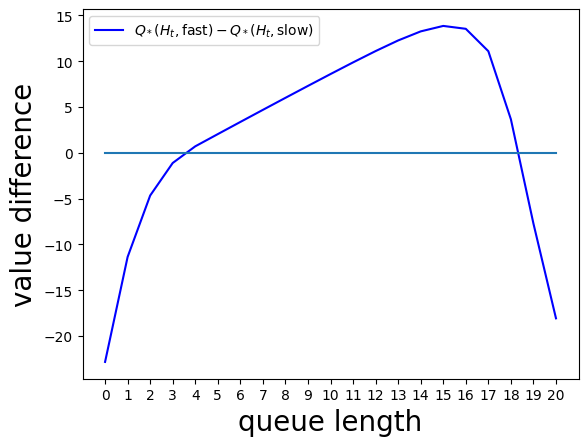

In [6]:
queue = Queue()
T = 1000
discount_factor = .999
abandonment_cost = 25

# value iteration
action_list = ['fast', 'slow']
Q = {a: np.zeros(queue.buffer_size + 1) for a in action_list}
for iter in range(T):
    Q_update = {a: np.zeros(queue.buffer_size + 1) for a in action_list}
    for a in action_list:
        for queue_length in range(queue.buffer_size + 1):
            prob_decrease, prob_same, prob_increase, prob_abandonment = queue.transition_probs(queue_length, a)
            V = np.maximum.reduce([Q[b] for b in action_list])
            Q_next = (
                prob_decrease * V[max(queue_length - 1, 0)] + 
                prob_same * V[queue_length] + 
                prob_increase * V[min(queue_length + 1, queue.buffer_size)]
            )
            Q_update[a][queue_length] = (
                (1 - prob_abandonment) * reward(a, (queue_length, 0), abandonment_cost=abandonment_cost) +
                prob_abandonment * reward(a, (queue_length, 1), abandonment_cost=abandonment_cost) +
                discount_factor * Q_next
            )
    Q = Q_update

# plot difference between value functions
import matplotlib.pyplot as plt
import pylab
queue_lengths = range(queue.buffer_size+1)
plt.plot(queue_lengths, [q_fast-q_slow for (q_fast,q_slow) in zip(Q['fast'],Q['slow'])], 'blue', label='$Q_*(H_t, \mathrm{fast}) - Q_*(H_t, \mathrm{slow})$')
plt.plot(queue_lengths, [0 for _ in queue_lengths], linestyle='-')
plt.xticks(queue_lengths)
plt.xlabel(r'queue length', fontsize=20)
plt.ylabel('value difference', fontsize=20)
pylab.legend(loc='best')
plt.show()

optimal action switches from fast to slow for queue length around 18, if abandonment cost is 25, fast cost is 30 and slow cost is 0. intuitively, this is because the cost for future abandomment is lower than the cost for serving fast right now.

# 2a)

In [55]:
import numpy as np

# cleaning robot example
class MopBot:
  def __init__(self,
               layout = np.array([[0, 0, 0, 0, 0]]),
               prob_spill = np.array([[.1, .1, .1, .1, .1]])):
    # elements of the map are:
    # 0: unobstructed cell
    # 1: obstructed cell
    # 5: unobstructed cell with spill (5 looks like S)
    # 6: unobstructed cell with agent (think Baymax of Big Hero 6)
    self.layout = layout
    self.map = layout.copy()
    self.map[0,0] = 6
    self.prob_spill = prob_spill
  
  def step(self, action):
    # determine current and target location
    location = np.where(self.map == 6)
    location = [int(location[0]),int(location[1])]
    target = location.copy()
    if action == 'left':
      target[1] -= 1
    elif action == 'right':
      target[1] += 1
    elif action == 'up':
      target[0] -= 1
    elif action == 'down':
      target[0] += 1

    # move agent if unobstructed
    height,width = np.shape(self.map)
    if (0 <= target[0] < height) and (0 <= target[1] < width) and (self.map[target[0],target[1]] != 1):
      self.map[location[0],location[1]] = 0
      self.map[target[0],target[1]] = 6

    # new spill
    spills = np.random.binomial(1, self.prob_spill)
    self.map += (self.map == 0) * spills * 5

    observation = self.map
    return observation

  def map_to_state(self, map):
    # state = concatenate([row, col], spill_configuration_array)
    row,col = np.where(map == 6)
    spills = (map == 5).flatten()
    state = np.concatenate((row, col, spills))
    return tuple(state)

  def state_to_map(self, state):
    location = state[:2]
    spills = np.array(state[2:])
    map = self.layout.copy()
    map[location[0],location[1]] = 6
    spill_map = spills.reshape(map.shape)
    map += (map == 0) * spill_map * 5
    return map

  def state_value_table(self):
    # allocate table with one value per state, initialized to zero
    height,width = np.shape(self.map)
    table = np.zeros([height,width] + height*width*[2])
    return table

  def state_list(self):
    height,width = np.shape(self.map)
    spill_list = [[]]
    for idx in range(height*width):
      spill_list = [s + [0] for s in spill_list] + [s + [1] for s in spill_list]
    return [tuple(np.concatenate(([row], [col], spills)))
            for row in range(height) 
            for col in range(width)
            for spills in spill_list]

  def transition_probs(self, state, action):
    # compute state transition probabilities
    # transition probs is an array with one probability per state
    map = self.state_to_map(state)
    location = np.where(map == 6)
    location = [int(location[0]),int(location[1])]

    # move agent
    target = location.copy()
    if action == 'left':
      target[1] -= 1
    elif action == 'right':
      target[1] += 1
    elif action == 'up':
      target[0] -= 1
    elif action == 'down':
      target[0] += 1
    # move agent if unobstructed
    height,width = np.shape(map)
    if (0 <= target[0] < height) and (0 <= target[1] < width) and (map[target[0],target[1]] != 1):
      map[location[0],location[1]] = 0
      map[target[0],target[1]] = 6

    transition_probs = self.state_value_table()

    # iterate through possible spill configurations
    spill_list = [np.array([], dtype='int64')]
    for idx in range(height*width):
      spill_list = [np.concatenate((s,[0])) for s in spill_list] + [np.concatenate((s,[1])) for s in spill_list]
    for spills in spill_list:
      spill_map = spills.reshape(map.shape)
      new_map = map.copy()
      new_map += (new_map == 0) * spill_map * 5
      new_state = self.map_to_state(new_map)
    
      transition_probs[new_state] += (
          np.prod(self.prob_spill ** spills * (1 - self.prob_spill) ** (1 - spills))
      )
    return transition_probs


def reward(map):
  return -np.sum(map==5)

In [59]:
## code for planning via value iteration in the simple default case of a single hallway
mb = MopBot(prob_spill=np.array([[0.25, 0.1, 0.1, 0.1, 0.1]]))

# compute optimal action value function
action_list = ['left','right','stay'] # note that these actions are specialized to the default case of a single hallway
Q = {a:mb.state_value_table() for a in action_list}
for iter in range(100):
  Q_update = {a:mb.state_value_table() for a in action_list}
  for a in action_list:
    for state in mb.state_list():
      probs = mb.transition_probs(state, a)
      Q_max = np.maximum.reduce([Q[b] for b in action_list])
      Q_update[a][state] = reward(mb.state_to_map(state)) + np.sum(np.multiply(probs, Q_max))
  Q = Q_update

# print map of optimal actions at time 0, with no spills
policy = [None, None, None, None, None] # note that the dimensions are specialized to the default case of a single hallway
for location in range(len(policy)):
  map = mb.layout.copy()
  map[0,location] = 6
  state = mb.map_to_state(map)
  policy[location] = action_list[np.argmax([Q[a][state] for a in action_list])]
print(policy)


['right', 'stay', 'left', 'left', 'left']
